In [1]:
import numpy as np
import glob 
import os
from pyrex.tools import find_roots, find_intercept
from pyrex.basics import write_HDF5, read_HDF5
from pyrex.main import *
from pyrex.core import *
import matplotlib.pyplot as plt
import lal
import lalsimulation as ls
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter.matchedfilter import make_frequency_series
from pycbc.filter import matched_filter_core,sigmasq
from pycbc.types import complex_same_precision_as

In [2]:
approximant1='IMRPhenomD'
approximant2='SEOBNRv4'
spin1x=0.
spin1y=0.
spin1z=0.
spin2x=0.
spin2y=0.
spin2z=0.
mass1=25.
mass2=25.
eccentricity=0.1
inclination=0.
distance=1.
coa_phase=0.
x=0.12

testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)

testPhenom_circ=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,0,x,inclination,distance,coa_phase)
testSEOB_circ=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,0,x,inclination,distance,coa_phase)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


In [3]:
total_mass = mass1 + mass2
total_mass_sec = total_mass * lal.MTSUN_SI

In [4]:
testPhenom.time[1] - testPhenom.time[0] 

0.00023170972663999478

In [5]:
testSEOB.time[2] - testSEOB.time[1] 

0.0002302949443730995

In [6]:
def zero_path_points(wave, threshold):
    path_points = np.abs(wave.h22) > threshold
    wave.h22[path_points] = 0

In [7]:
zero_path_points(testPhenom, 1.e-18)
zero_path_points(testSEOB, 1.e-18)

Text(0.5, 1.0, 'q= 1.0, e= 0.1')

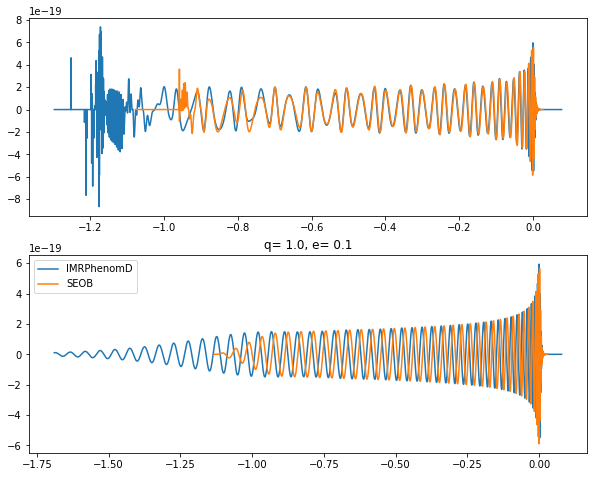

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
ax1.plot(testPhenom.time[1000:] ,np.real(testPhenom.h22[1000:]),label='IMRPhenomD')
ax1.plot(testSEOB.time,np.real(testSEOB.h22),label='SEOB')
ax2.plot(testPhenom_circ.time[2000:] ,np.real(testPhenom_circ.h22[2000:]),label='IMRPhenomD')
ax2.plot(testSEOB_circ.time,np.real(testSEOB_circ.h22),label='SEOB')
plt.legend()
plt.title('q= '+str(mass1/mass2)+ ', e= '+str(eccentricity))

In [116]:
_snr = None
def modify_match(vec1, vec2, vec3, vec4, psd=None, low_frequency_cutoff=None,
          high_frequency_cutoff=None, v1_norm=None, v2_norm=None):
    """ Return the match between the two TimeSeries or FrequencySeries.

    Return the match between two waveforms. This is equivalent to the overlap
    maximized over time and phase.

    Parameters
    ----------
    vec1 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    vec2 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    psd : Frequency Series
        A power spectral density to weight the overlap.
    low_frequency_cutoff : {None, float}, optional
        The frequency to begin the match.
    high_frequency_cutoff : {None, float}, optional
        The frequency to stop the match.
    v1_norm : {None, float}, optional
        The normalization of the first waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    v2_norm : {None, float}, optional
        The normalization of the second waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.

    Returns
    -------
    match: float
    index: int
        The number of samples to shift to get the match.
    """
    
    htilde = make_frequency_series(vec1)    
    stilde = make_frequency_series(vec2)
    h_imag=make_frequency_series(vec3)*1j
    s_im=make_frequency_series(vec4)*1j
    htilde=htilde+h_imag
    stilde=stilde+s_im
    
    

    N = (len(htilde)-1) * 2

    global _snr
   
    if _snr is None or _snr.dtype != htilde.dtype or len(_snr) != N:
        _snr = np.zeros(N,dtype=complex_same_precision_as(vec1))
   
    snr, a, snr_norm = matched_filter_core(htilde,stilde,psd,low_frequency_cutoff,high_frequency_cutoff, v1_norm, out=None)
    maxsnr, max_id = snr.abs_max_loc()
    if v2_norm is None:
        v2_norm = sigmasq(stilde, psd, low_frequency_cutoff, high_frequency_cutoff)
    return maxsnr * snr_norm / np.sqrt(v2_norm), max_id

In [117]:
def resizeWave(time,strain,newtime,samplerate):  
    deltaT=1./samplerate
    newtime=np.arange(min(newtime),max(newtime),deltaT)
    inter_real=spline(time,np.real(strain))
    inter_im=spline(time,np.imag(strain))
    time_real=TimeSeries(inter_real(newtime),delta_t=deltaT)
    time_im=TimeSeries(inter_im(newtime),delta_t=deltaT)
    return time_real,time_im

def compute_match(testtime,testh,timemodel,mdlh,newtm,samplerate):
    nrdt,nid=resizeWave(testtime,testh,newtm,samplerate)
    mdt,mdi=resizeWave(timemodel,mdlh,newtm,samplerate)    
    f_lower=25.
    tlen=len(nrdt)
    delta_f = 1.0 / nrdt.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_lower)
    cmatch=modify_match(nrdt,mdt,nid,mdi,psd=psd,low_frequency_cutoff=f_lower)
    return cmatch[0]

In [147]:
total_mass = mass1 + mass2
total_mass_sec = total_mass * lal.MTSUN_SI

In [148]:
def complex_inner_prod(wave1, wave2, timebounds, samplerate, i1=0, i2=0):
    [[h1real, h1imag], [h2real, h2imag]] = [resizeWave(wave.time[i0:], wave.h22[i0:], timebounds, samplerate) 
                                            for wave, i0 in zip((wave1, wave2), (i1, i2))]
    
    #return h1real, h1imag, h2real, h2imag
    
    h1 = h1real.data + 1.j * h1imag.data
    h2 = h2real.data + 1.j * h2imag.data
    return np.sum(h1 * np.conjugate(h2))

In [150]:
def complex_match(wave1, wave2, timebounds, samplerate, i1=0, i2=0):
    norm1, norm2 = [np.sqrt(np.absolute(complex_inner_prod(wave, wave, timebounds, samplerate, i0, i0)))
                    for wave, i0 in zip((wave1, wave2), (i1, i2))]
    return complex_inner_prod(wave1, wave2, timebounds, samplerate, i1, i2) / (norm1 * norm2)

In [168]:
complex_match(testPhenom, testPhenom, [-0.6, 0], 4096, i1=2000)

(1+0j)

In [184]:
endtimes = np.linspace(-0.1, 0.05, 50)
mismatches = np.array([1. - np.absolute(complex_match(testPhenom, testSEOB, [-0.6, t], 5000, i1=0, i2=0)) 
              for t in endtimes])
mismatches_circ = np.array([1. - np.absolute(complex_match(testPhenom_circ, testSEOB_circ, [-0.6, t], 5000, i1=0, i2=0)) 
              for t in endtimes])

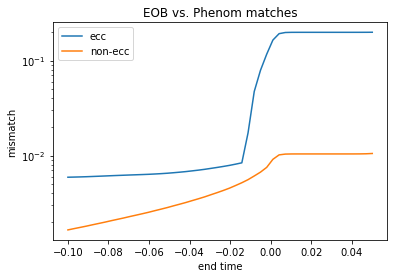

In [185]:
plt.figure()
plt.semilogy(endtimes, mismatches, label='ecc')
plt.semilogy(endtimes, mismatches_circ, label='non-ecc')
plt.xlabel('end time')
plt.ylabel('mismatch')
plt.title('EOB vs. Phenom matches')
plt.legend()